In [9]:
# TODO: przejrzeć kod i dopisywać komentarze

The aim of this notebook is to investigate characteristics of positive
crop pairs when using various IoU ranges:

1. What's the fraction of positive pairs containing at least 1 common organ
depending on IoU range?

2. What's the distribution of crop centers depending on IoU range (hopefully
uniform for all ranges - to check any potential biases)?

In [10]:
import sys 
sys.path.append('..')

In [11]:
import matplotlib.pyplot as plt
import monai.transforms as T

from pathlib import Path
from tqdm import tqdm

from monai.data import DataLoader, Dataset
from monai.utils import set_determinism

from src.loaders import get_finetune_data
from src.transforms import IoUCropd

Let's split possible IoU values into a few (approximately even) intervals. 

In [12]:
DATA_DIR = '../data/finetune_preprocessed_2d'
SPLIT_PATH = '../data/split.json'
IOU_RANGES = [  # Both sides included in the ranges
    (0, 0.01),
    (0.01, 0.3),
    (0.3, 0.6),
    (0.6, 1.0)
]
N_EPOCHS = 10

In [13]:
set_determinism(4294967295)

In [14]:
train_data, val_data = get_finetune_data(
    Path(DATA_DIR),
    Path(SPLIT_PATH)
)

data = train_data + val_data

In [15]:
def get_transforms(min_iou, max_iou):
    transforms = [
        T.LoadImaged(
            keys=['img', 'label'],
            reverse_indexing=False  # Don't apply any auto rotation when loading
        ),
        T.ScaleIntensityRanged(  # 2D images stored in uint8
            keys=['img'],
            a_min=0,
            a_max=255,
            b_min=0.0, 
            b_max=1.0,
        ),
        T.EnsureChannelFirstd(
            keys=['img', 'label']
        ),
        T.EnsureTyped(
            keys=['img', 'label'], 
            track_meta=False
        ),
        IoUCropd(
            keys=['img', 'label'], 
            spatial_dims=2,
            min_iou=min_iou, 
            max_iou=max_iou,
            max_retries_total=200,
            debug=True
        )
    ]

    return T.Compose(transforms)

Let's iterate over all data for `N_EPOCHS` and gather statistics of interest.

The centers of crops have to be relative due to various CT sizes.

In [16]:
stat_dicts = {
    iou_range: {
        'overlaps': [],
        'centers': []
    }
    for iou_range in IOU_RANGES
}

In [17]:
def get_relative_center(slices, shape):
    # + 48 as crop size is 96
    center_y = slices[0].start + 48
    center_x = slices[1].start + 48

    return (center_y/shape[2], center_x/shape[3])

In [18]:
def gather_stats_one_epoch(loader, stat_dict):
    for data_dict in loader:
        img = data_dict['img']

        # Gather organ overlap
        organs1 = set(data_dict['label1'].unique().numpy().astype(int))
        organs2 = set(data_dict['label2'].unique().numpy().astype(int))

        # Skip cases where both images show bg only
        organs1.remove(0)
        organs2.remove(0)
        if len(organs1) != 0 or len(organs2) != 0:
            stat_dict['overlaps'].append(
                len(organs1.intersection(organs2)) > 0
            )

        # Gather centers
        img1_slices = eval(data_dict['img1_slices'][0])
        img2_slices = eval(data_dict['img2_slices'][0])

        stat_dict['centers'].append(
            get_relative_center(img1_slices, img.shape)
        )
        stat_dict['centers'].append(
            get_relative_center(img2_slices, img.shape)
        )

In [19]:
for iou_range in IOU_RANGES:
    print(f'Gathering stats for {iou_range}')
    
    ds = Dataset(
        data=data[:40], # FIXME: full dataset
        transform=get_transforms(*iou_range)
    )

    loader = DataLoader(
        ds,
        batch_size=1,
        num_workers=0,
        shuffle=True
    )

    for i in tqdm(range(N_EPOCHS)):
        gather_stats_one_epoch(loader, stat_dicts[iou_range])

/home/ditto/envs/sslct/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


Gathering stats for (0, 0.01)


100%|██████████| 10/10 [00:19<00:00,  1.90s/it]


Gathering stats for (0.01, 0.3)


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


Gathering stats for (0.3, 0.6)


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


Gathering stats for (0.6, 1.0)


100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


In [20]:
for iou_range in IOU_RANGES:
    overlaps = stat_dicts[iou_range]['overlaps']
    stat_dicts[iou_range]['overlap_ratio'] = (
        sum(overlaps) / len(overlaps)
    )

    centers = stat_dicts[iou_range]['centers']

    ys_center = [center[0] for center in centers]
    y_mean = sum(ys_center) / len(ys_center)
    xs_center = [center[1] for center in centers]
    x_mean = sum(xs_center) / len(xs_center)

    stat_dicts[iou_range]['avg_center'] = (x_mean, y_mean)  # Swap coords for plt

{'[0, 0.01]': 0.16326530612244897, '[0.01, 0.3]': 0.5555555555555556, '[0.3, 0.6]': 0.7509578544061303, '[0.6, 1.0]': 0.8723404255319149}


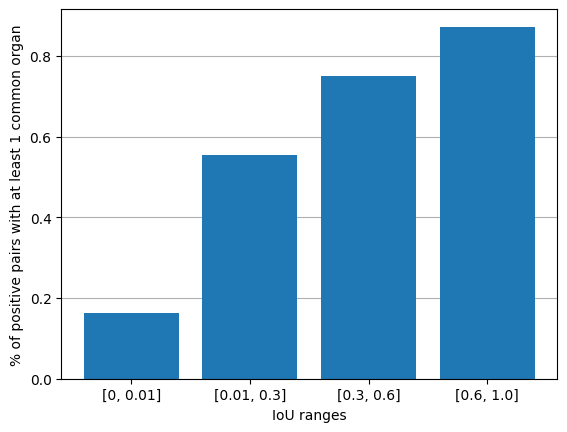

In [21]:
plt.rc('axes', axisbelow=True)  # Force grid behind bars

ratios = {
    str(list(iou_range)): stat_dicts[iou_range]['overlap_ratio']
    for iou_range in IOU_RANGES
}

print(ratios)

plt.grid(axis='y')
plt.xlabel('IoU ranges')
plt.ylabel('% of positive pairs with at least 1 common organ')
plt.bar(ratios.keys(), ratios.values())
plt.show()

As expected, ranges with higher IoU values entail pairs that are more similar
semantically (i.e. contain same organs).

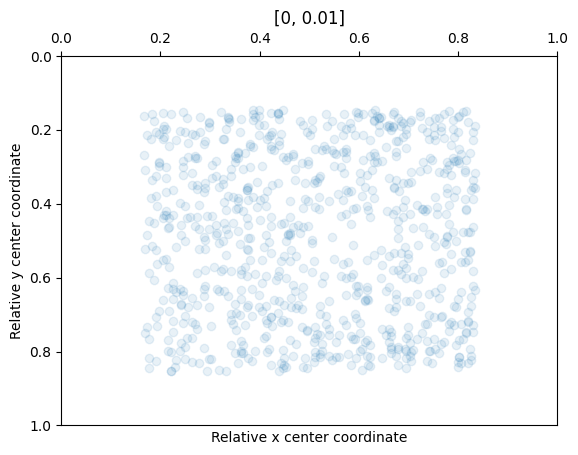

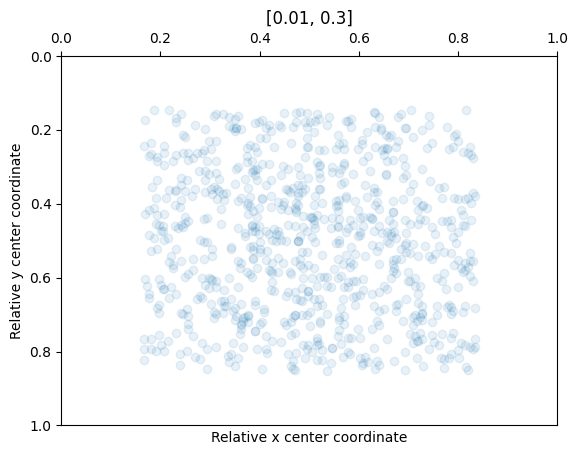

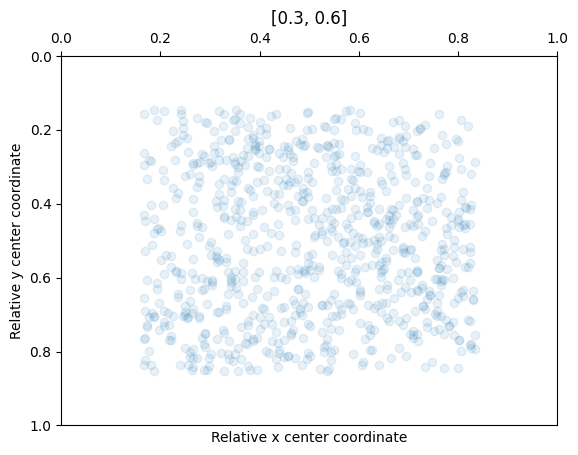

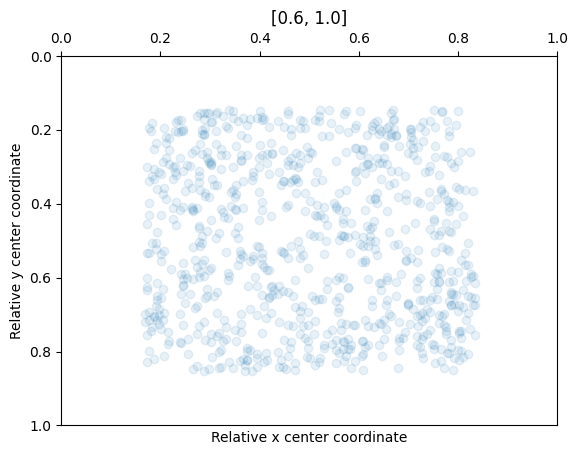

In [22]:
for i, iou_range in enumerate(IOU_RANGES):

    _, ax = plt.subplots()

    xs = [
        center[1] for center in stat_dicts[iou_range]['centers']
    ]
    ys = [
        center[0] for center in stat_dicts[iou_range]['centers']
    ]

    ax.scatter(xs, ys, alpha=0.1)
    ax.xaxis.tick_top()
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)
    ax.set_xlabel('Relative x center coordinate') 
    ax.set_ylabel('Relative y center coordinate')
    ax.set_title(list(iou_range))

    plt.show()
    plt.close()

One can see that distribution of crops centers is similar for all the ranges.